In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.integrate
from functions import *

In [2]:
nodes

,coordinate_x,coordinate_y,displacement_x,displacement_y,load_x,load_y
0,0,0,0.0,0.0,NaN,NaN
1,10,0,NaN,NaN,0.0,-100.0
2,20,0,0.0,0.0,NaN,NaN
3,5,10,NaN,NaN,0.0,0.0
4,15,10,NaN,NaN,0.0,0.0


In [3]:
elements

,start_node,end_node,area,Youngs_modulus,density
0,0,1,0.000002,1.000000e+10,2700
1,1,2,0.000002,1.000000e+10,2700
2,0,3,0.000002,1.000000e+10,2700
3,1,3,0.000002,1.000000e+10,2700
4,1,4,0.000002,1.000000e+10,2700
5,4,2,0.000002,1.000000e+10,2700
6,3,4,0.000002,1.000000e+10,2700


In [4]:
elements[['length', 'stiffness_matrix']] = elements.apply(element_stiffness, axis=1, result_type='expand')
elements['mass_matrix'] = elements.apply(element_mass, axis=1)
elements

,start_node,end_node,area,Youngs_modulus,density,length,stiffness_matrix,mass_matrix
0,0,1,0.000002,1.000000e+10,2700,10.00000,"[[2000.0, 0.0, -2000.0, -0.0], [0.0, 0.0, -0.0...","[[0.026999999999999996, 0.0, 0.0, 0.0], [0.0, ..."
1,1,2,0.000002,1.000000e+10,2700,10.00000,"[[2000.0, 0.0, -2000.0, -0.0], [0.0, 0.0, -0.0...","[[0.026999999999999996, 0.0, 0.0, 0.0], [0.0, ..."
2,0,3,0.000002,1.000000e+10,2700,11.18034,"[[357.7708763999663, 715.5417527999326, -357.7...","[[0.030186917696247158, 0.0, 0.0, 0.0], [0.0, ..."
3,1,3,0.000002,1.000000e+10,2700,11.18034,"[[357.7708763999663, -715.5417527999326, -357....","[[0.030186917696247158, 0.0, 0.0, 0.0], [0.0, ..."
4,1,4,0.000002,1.000000e+10,2700,11.18034,"[[357.7708763999663, 715.5417527999326, -357.7...","[[0.030186917696247158, 0.0, 0.0, 0.0], [0.0, ..."
5,4,2,0.000002,1.000000e+10,2700,11.18034,"[[357.7708763999663, -715.5417527999326, -357....","[[0.030186917696247158, 0.0, 0.0, 0.0], [0.0, ..."
6,3,4,0.000002,1.000000e+10,2700,10.00000,"[[2000.0, 0.0, -2000.0, -0.0], [0.0, 0.0, -0.0...","[[0.026999999999999996, 0.0, 0.0, 0.0], [0.0, ..."


In [5]:
K = elements.apply(global_stiffness, axis=1).sum()
M = elements.apply(global_mass, axis=1).sum()

In [6]:
U = nodes[['displacement_x', 'displacement_y']].to_numpy()
U = U.ravel()
A = np.isnan(U)

P = nodes[['load_x', 'load_y']].to_numpy()
P = P.ravel()
B = np.isnan(P)

KAA, KAB, KBA, KBB = partition(K, A, B)
MAA, MAB, MBA, MBB = partition(M, A, B)

In [7]:
UB = U[B]
PA = P[A]
UA = np.dot(np.linalg.inv(KAA),(PA-np.dot(KAB,UB)))
U[A] = UA
PB = np.dot(KBA,UA)+np.dot(KBB,UB)
P[B] = PB

result = nodes.copy()
result[['displacement_x', 'displacement_y']] = U.reshape(-1,2)
result[['load_x', 'load_y']] = P.reshape(-1,2)
result

,coordinate_x,coordinate_y,displacement_x,displacement_y,load_x,load_y
0,0,0,0.000000e+00,0.000000,25.0,50.0
1,10,0,3.517113e-19,-0.082377,0.0,-100.0
2,20,0,0.000000e+00,0.000000,-25.0,50.0
3,5,10,1.250000e-02,-0.041189,0.0,0.0
4,15,10,-1.250000e-02,-0.041189,0.0,0.0


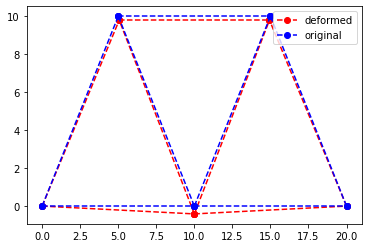

In [8]:
factor = 5
result['deformed_x'] = result['coordinate_x'] + factor*result['displacement_x']
result['deformed_y'] = result['coordinate_y'] + factor*result['displacement_y']

connectpoints(result['deformed_x'], result['deformed_y'],0,1,True,True)
connectpoints(result['deformed_x'], result['deformed_y'],1,2)
connectpoints(result['deformed_x'], result['deformed_y'],0,3)
connectpoints(result['deformed_x'], result['deformed_y'],1,3)
connectpoints(result['deformed_x'], result['deformed_y'],1,4)
connectpoints(result['deformed_x'], result['deformed_y'],2,4)
connectpoints(result['deformed_x'], result['deformed_y'],3,4)

connectpoints(result['coordinate_x'], result['coordinate_y'],0,1,False,True)
connectpoints(result['coordinate_x'], result['coordinate_y'],1,2,False)
connectpoints(result['coordinate_x'], result['coordinate_y'],0,3,False)
connectpoints(result['coordinate_x'], result['coordinate_y'],1,3,False)
connectpoints(result['coordinate_x'], result['coordinate_y'],1,4,False)
connectpoints(result['coordinate_x'], result['coordinate_y'],2,4,False)
connectpoints(result['coordinate_x'], result['coordinate_y'],3,4,False)

plt.legend()
plt.show()

In [9]:
frequencies, modes = modal_analysis(MAA, KAA)

In [32]:
deltaT = 0.001
T = 1000

a = np.zeros((len(UA),1))
a[:,0] = np.transpose(UA)
a_dot = np.zeros((len(UA),1))
a_ddot = -np.dot(np.dot(np.linalg.inv(MAA), KAA), a)
f = np.zeros((len(PA),T))
f[:,0] = np.transpose(PA)

a, a_dot, a_ddot = Newmark_Beta(MAA, KAA, f, a, a_dot, a_ddot, deltaT, T)

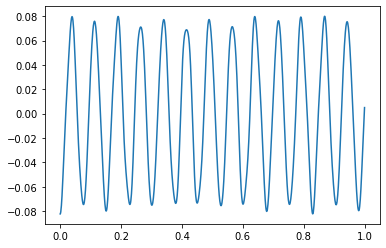

In [11]:
plt.plot(np.linspace(0, T*deltaT, T), a[1,:])
plt.show()

In [12]:
dt = 0.001
t = 1000

d = np.zeros((len(UA),1))
d[:,0] = np.transpose(UA)
d_dot = np.zeros((len(UA),1))
v = np.zeros((len(UA),1))
v_dot = -np.dot(np.dot(np.linalg.inv(MAA), KAA), d)

d, d_dot, v, v_dot = Alpha(MAA, KAA, d, d_dot, v, v_dot, dt, t)

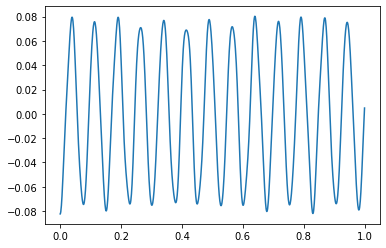

In [13]:
plt.plot(np.linspace(0, t*dt, t), d[1,:])
plt.show()

In [14]:
T_range = [0,1]
x_0 = np.transpose(np.hstack((UA,np.zeros(len(UA)))))
time, x = Runge_Kutta(MAA, KAA, T_range, x_0)

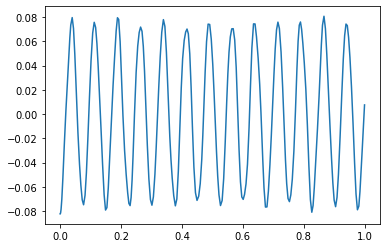

In [15]:
plt.plot(time, x[1,:])
plt.show()

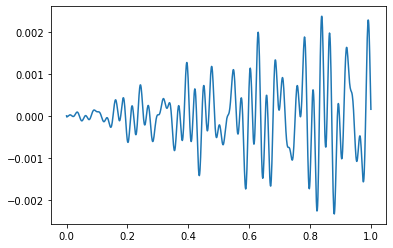

In [16]:
plt.plot(np.linspace(0, T*deltaT, T), a[1,:]-d[1,:])

In [17]:
CAA, damping_factors = damping_factors(frequencies, frequencies[0], frequencies[1], 0.1, 0.1, MAA, KAA)

In [18]:
deltaT = 0.001
T = 1000

a = np.zeros((len(UA),1))
a[:,0] = np.transpose(UA)
a_dot = np.zeros((len(UA),1))
a_ddot = np.dot(np.linalg.inv(MAA), -np.dot(CAA, a_dot)-np.dot(KAA, a))
f = np.zeros((len(PA),T))
f[:,0] = np.transpose(PA)

a, a_dot, a_ddot = Newmark_Beta_damping(MAA, CAA, KAA, f, a, a_dot, a_ddot, deltaT, T)

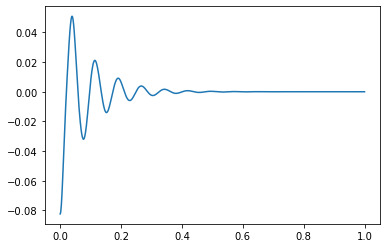

In [19]:
plt.plot(np.linspace(0, T*deltaT, T), a[1,:])
plt.show()

In [20]:
dt = 0.001
t = 1000

d = np.zeros((len(UA),1))
d[:,0] = np.transpose(UA)
d_dot = np.zeros((len(UA),1))
v = np.zeros((len(UA),1))
v_dot = np.dot(np.linalg.inv(MAA), -np.dot(CAA, d_dot)-np.dot(KAA, d))

d, d_dot, v, v_dot = Alpha_damping(MAA, CAA, KAA, d, d_dot, v, v_dot, dt, t)

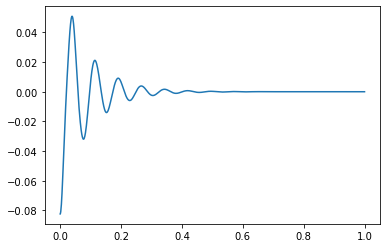

In [21]:
plt.plot(np.linspace(0, t*dt, t), d[1,:])
plt.show()

In [22]:
T_range = [0,1]
x_0 = np.transpose(np.hstack((UA,np.zeros(len(UA)))))
time, x = Runge_Kutta_damping(MAA, CAA, KAA, T_range, x_0)

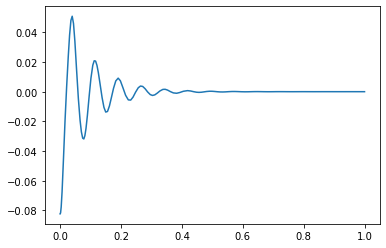

In [23]:
plt.plot(time, x[1,:])
plt.show()

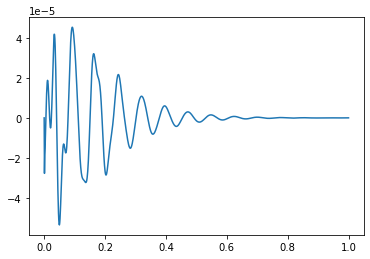

In [24]:
plt.plot(np.linspace(0, T*deltaT, T), a[1,:]-d[1,:])

In [25]:
A = transition_matrix_Newmark_Beta(MAA, KAA, deltaT)
B = force_matrix_Newmark_Beta(MAA, KAA, deltaT)

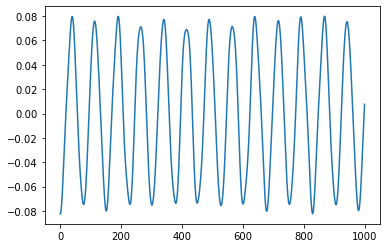

In [26]:
a = np.zeros((3*len(UA),1))
a[0:6,0] = np.transpose(UA)
for i in range(T):
  a_new = np.dot(A, a[:,i])
  a = np.append(a, a_new.reshape(3*len(UA),1), axis=1)

plt.plot(a[1,:])

In [34]:
data = generate_pseudo_data(a, T, 0.1)

ValueError: operands could not be broadcast together with shapes (1000,) (1001,) 

In [28]:
print(np.shape(data))

(18, 1001)


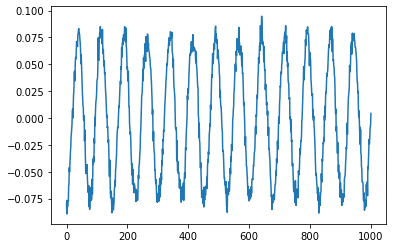

In [29]:
plt.plot(data[1,:])

In [30]:
H = observe_displacements(A)

In [33]:
x = np.zeros((3*len(UA),1))
x[0:6,0] = np.transpose(UA)
f = np.zeros((len(PA),T))
f[:,0] = np.transpose(PA)
x, energy = Kalman_filter(A, B, H, x, f, data, 1, 1, 1, T)

ValueError: operands could not be broadcast together with shapes (18,) (6,) 

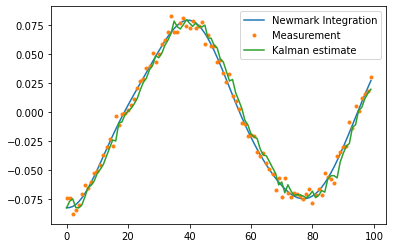

In [ ]:
plt.plot(a[1,:100], label='Newmark Integration')
plt.plot(data[1,:100], '.', label='Measurement')
plt.plot(x[1,:100], label='Kalman estimate')

plt.legend()
plt.show()

In [ ]:
elements2[['length', 'stiffness_matrix']] = elements2.apply(element_stiffness, axis=1, result_type='expand')
elements2['mass_matrix'] = elements2.apply(element_mass, axis=1)
elements2

,start_node,end_node,area,Youngs_modulus,density,length,stiffness_matrix,mass_matrix
0,0,1,0.000002,1.000000e+10,3500,10.00000,"[[2000.0, 0.0, -2000.0, -0.0], [0.0, 0.0, -0.0...","[[0.034999999999999996, 0.0, 0.0, 0.0], [0.0, ..."
1,1,2,0.000002,1.000000e+10,3500,10.00000,"[[2000.0, 0.0, -2000.0, -0.0], [0.0, 0.0, -0.0...","[[0.034999999999999996, 0.0, 0.0, 0.0], [0.0, ..."
2,0,3,0.000002,1.000000e+10,3500,11.18034,"[[357.7708763999663, 715.5417527999326, -357.7...","[[0.03913118960624632, 0.0, 0.0, 0.0], [0.0, 0..."
3,1,3,0.000002,1.000000e+10,3500,11.18034,"[[357.7708763999663, -715.5417527999326, -357....","[[0.03913118960624632, 0.0, 0.0, 0.0], [0.0, 0..."
4,1,4,0.000002,1.000000e+10,3500,11.18034,"[[357.7708763999663, 715.5417527999326, -357.7...","[[0.03913118960624632, 0.0, 0.0, 0.0], [0.0, 0..."
5,4,2,0.000002,1.000000e+10,3500,11.18034,"[[357.7708763999663, -715.5417527999326, -357....","[[0.03913118960624632, 0.0, 0.0, 0.0], [0.0, 0..."
6,3,4,0.000002,1.000000e+10,3500,10.00000,"[[2000.0, 0.0, -2000.0, -0.0], [0.0, 0.0, -0.0...","[[0.034999999999999996, 0.0, 0.0, 0.0], [0.0, ..."


In [ ]:
K2 = elements2.apply(global_stiffness, axis=1).sum()
M2 = elements2.apply(global_mass, axis=1).sum()

In [ ]:
U = nodes[['displacement_x', 'displacement_y']].to_numpy()
U = U.ravel()
A = np.isnan(U)

P = nodes[['load_x', 'load_y']].to_numpy()
P = P.ravel()
B = np.isnan(P)
KAA2, KAB2, KBA2, KBB2 = partition(K2, A, B)
MAA2, MAB2, MBA2, MBB2 = partition(M2, A, B)
UB = U[B]
PA = P[A]
UA = np.dot(np.linalg.inv(KAA2),(PA-np.dot(KAB2,UB)))
U[A] = UA
PB = np.dot(KBA2,UA)+np.dot(KBB2,UB)
P[B] = PB

In [ ]:
A2 = transition_matrix_Newmark_Beta(MAA2, KAA2, deltaT)
A = transition_matrix_Newmark_Beta(MAA, KAA, deltaT)
B = force_matrix_Newmark_Beta(MAA, KAA, deltaT)
B2 = force_matrix_Newmark_Beta(MAA2, KAA2, deltaT)

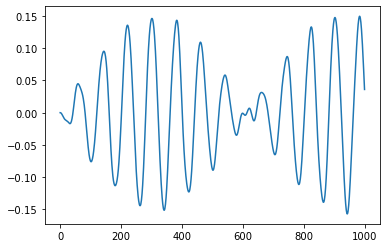

In [ ]:
a_new_model = np.zeros((3*len(UA),1))
a_new_model[0:6,0] = np.transpose(UA)
for i in range(T):
  a_new = np.dot(A2, a_new_model[:,i])
  a_new_model = np.append(a_new_model, a_new.reshape(3*len(UA),1), axis=1)
plt.plot(a_new_model[1,:]-a[1,:])

In [ ]:
a = np.zeros((len(UA),1))
a[:,0] = np.transpose(UA)
a_dot = np.zeros((len(UA),1))
a_ddot = np.dot(np.linalg.inv(MAA), -np.dot(CAA, a_dot)-np.dot(KAA, a))
f = np.zeros((len(PA),T))
f[:,0] = np.transpose(PA)

a, a_dot, a_ddot = Newmark_Beta(MAA, KAA, f, a, a_dot, a_ddot, deltaT, T)
data2 = generate_pseudo_data(a_new_model, T, 0.1)

In [ ]:
print(np.shape(B))

(18, 6)


In [ ]:
a = np.zeros((3*len(UA),1))
a[0:6,0] = np.transpose(UA)
for i in range(T-1):
  a_new = np.dot(A, a[:,i])
  a = np.append(a, a_new.reshape(3*len(UA),1), axis=1)

In [ ]:
x = np.zeros((3*len(UA),1))
x[0:6,0] = np.transpose(UA)
f = np.zeros((len(PA),T))
f[:,0] = np.transpose(PA)
x = Kalman_filter(A, B, H, x, f, data2, 0.1, 0.1, 0.1, T)

TypeError: tuple indices must be integers or slices, not tuple

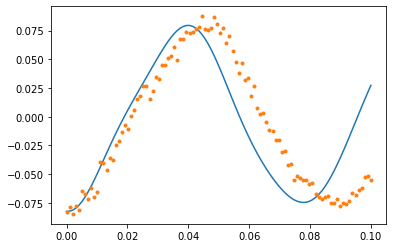

In [ ]:
scale = 0.1
plt.plot(np.linspace(0, T*deltaT*scale, int(T*scale)), a[1,:int(T*scale)], label='Newmark Integration')
plt.plot(np.linspace(0, T*deltaT*scale, int(T*scale)), data2[1,:int(T*scale)], '.', label='Measurement')
plt.plot(np.linspace(0, T*deltaT*scale, int(T*scale)), x[1,:int(T*scale)], label='Kalman estimate')

plt.legend()
plt.show()

In [71]:
def random_force(param, T):
  return np.tile(np.array(np.random.normal(param,40, (6,1))), (1,T))

[[ -57.66098     -57.66098     -57.66098    ...  -57.66098
   -57.66098     -57.66098   ]
 [-130.51929361 -130.51929361 -130.51929361 ... -130.51929361
  -130.51929361 -130.51929361]
 [ -41.94356749  -41.94356749  -41.94356749 ...  -41.94356749
   -41.94356749  -41.94356749]
 [ -67.13581958  -67.13581958  -67.13581958 ...  -67.13581958
   -67.13581958  -67.13581958]
 [ -96.44274872  -96.44274872  -96.44274872 ...  -96.44274872
   -96.44274872  -96.44274872]
 [-136.17687139 -136.17687139 -136.17687139 ... -136.17687139
  -136.17687139 -136.17687139]]


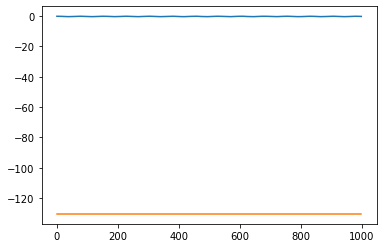

In [72]:
f = random_force(-100, T)
# f = np.random.normal(-100,10, (len(PA),T))
print(f)
a = np.zeros((len(UA),1))
a[:,0] = np.transpose(UA)
a_dot = np.zeros((len(UA),1))
a_ddot = np.dot(np.linalg.inv(MAA), -np.dot(CAA, a_dot)-np.dot(KAA, a))
a, a_dot, a_ddot = Newmark_Beta(MAA, KAA, f, a, a_dot, a_ddot, deltaT, T)
plt.plot(a[1,:])
plt.plot(f[1,:])

In [73]:
data = generate_pseudo_data(a, T-1, 0.1)

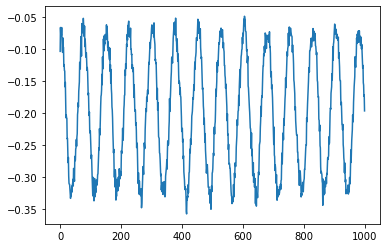

In [74]:
plt.plot(data[1,:])

In [35]:
print(np.shape(data))

(6, 1000)


-117.77454078859041


(array([ 8., 44., 22., 42., 37., 13., 22., 31., 15., 16., 18., 33., 24.,
        48., 30., 51., 27., 27., 43., 34., 70., 69., 42., 69., 43., 57.,
        14., 17.,  8., 26.]),
 array([-186.12253441, -182.24578503, -178.36903566, -174.49228628,
        -170.61553691, -166.73878753, -162.86203816, -158.98528878,
        -155.10853941, -151.23179003, -147.35504066, -143.47829128,
        -139.60154191, -135.72479253, -131.84804316, -127.97129378,
        -124.09454441, -120.21779503, -116.34104566, -112.46429628,
        -108.58754691, -104.71079753, -100.83404816,  -96.95729878,
         -93.08054941,  -89.20380003,  -85.32705066,  -81.45030128,
         -77.57355191,  -73.69680253,  -69.82005316]),
 <BarContainer object of 30 artists>)

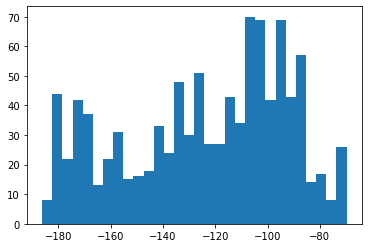

In [77]:
x = np.zeros((3*len(UA),1))
x[0:6,0] = np.transpose(UA)
param, energy_list, X = Metropolis_Hasting(A, B, H, x, random_force, data, 1, 1, 1, -80, 10, 5, T, 1000)
index = np.argmin(energy_list)
mean_MAP = param[index]
print(mean_MAP)
plt.hist(param, bins=30)

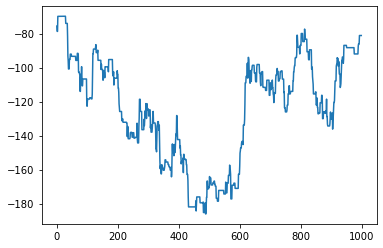

In [78]:
plt.plot(param)

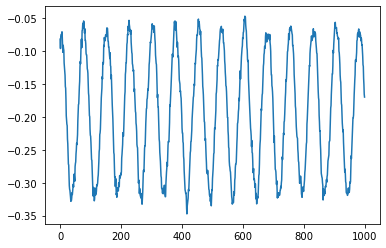

In [79]:
plt.plot(X[index][1,:])